https://github.com/cmd23333/Faster-rcnn-tensorflow2.x    
https://zhuanlan.zhihu.com/p/56710152  （简单实例用python实现）  
https://www.yanxishe.com/TextTranslation/1304  （简单实例用python实现）  
https://cloud.tencent.com/developer/article/1063601?from=article.detail.1630476 （从编程角度描述faster rcnn架构）

https://zhuanlan.zhihu.com/p/69250914 
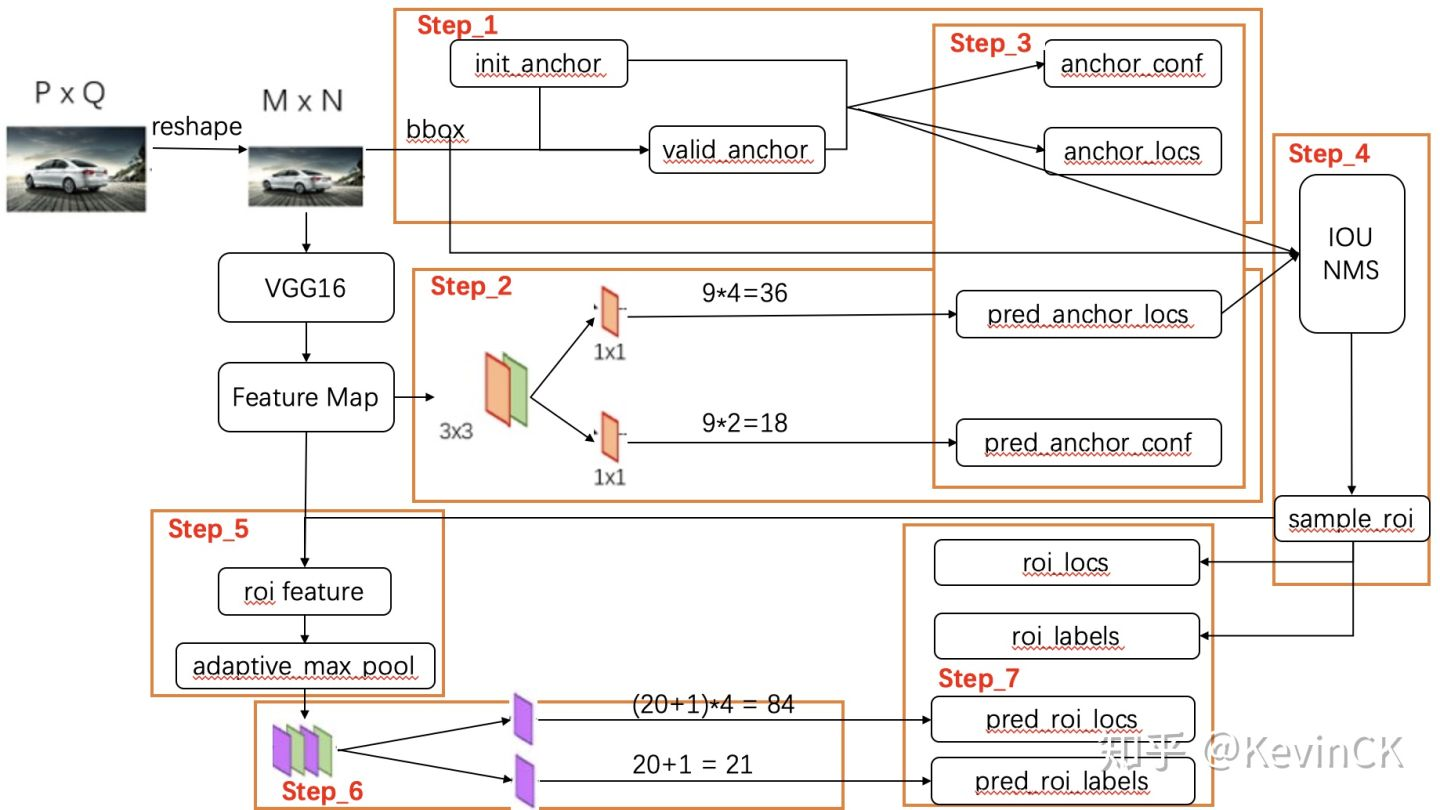

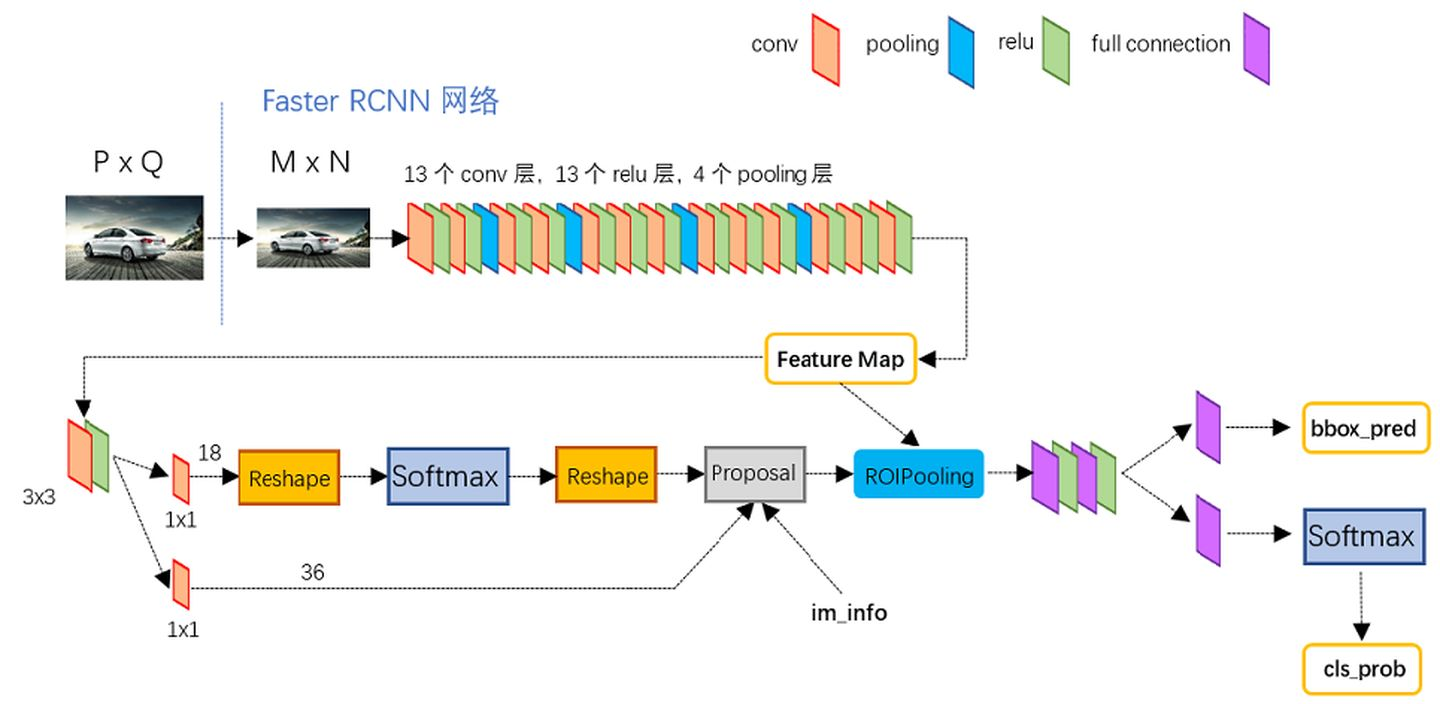

https://zhuanlan.zhihu.com/p/31426458  
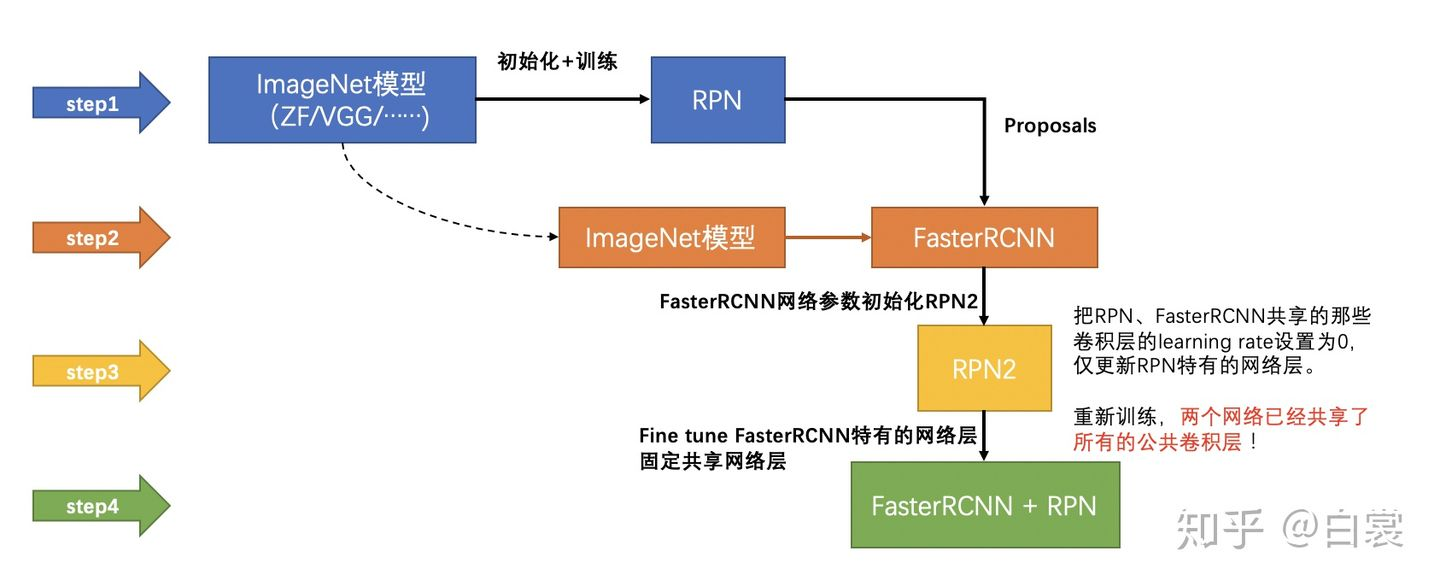

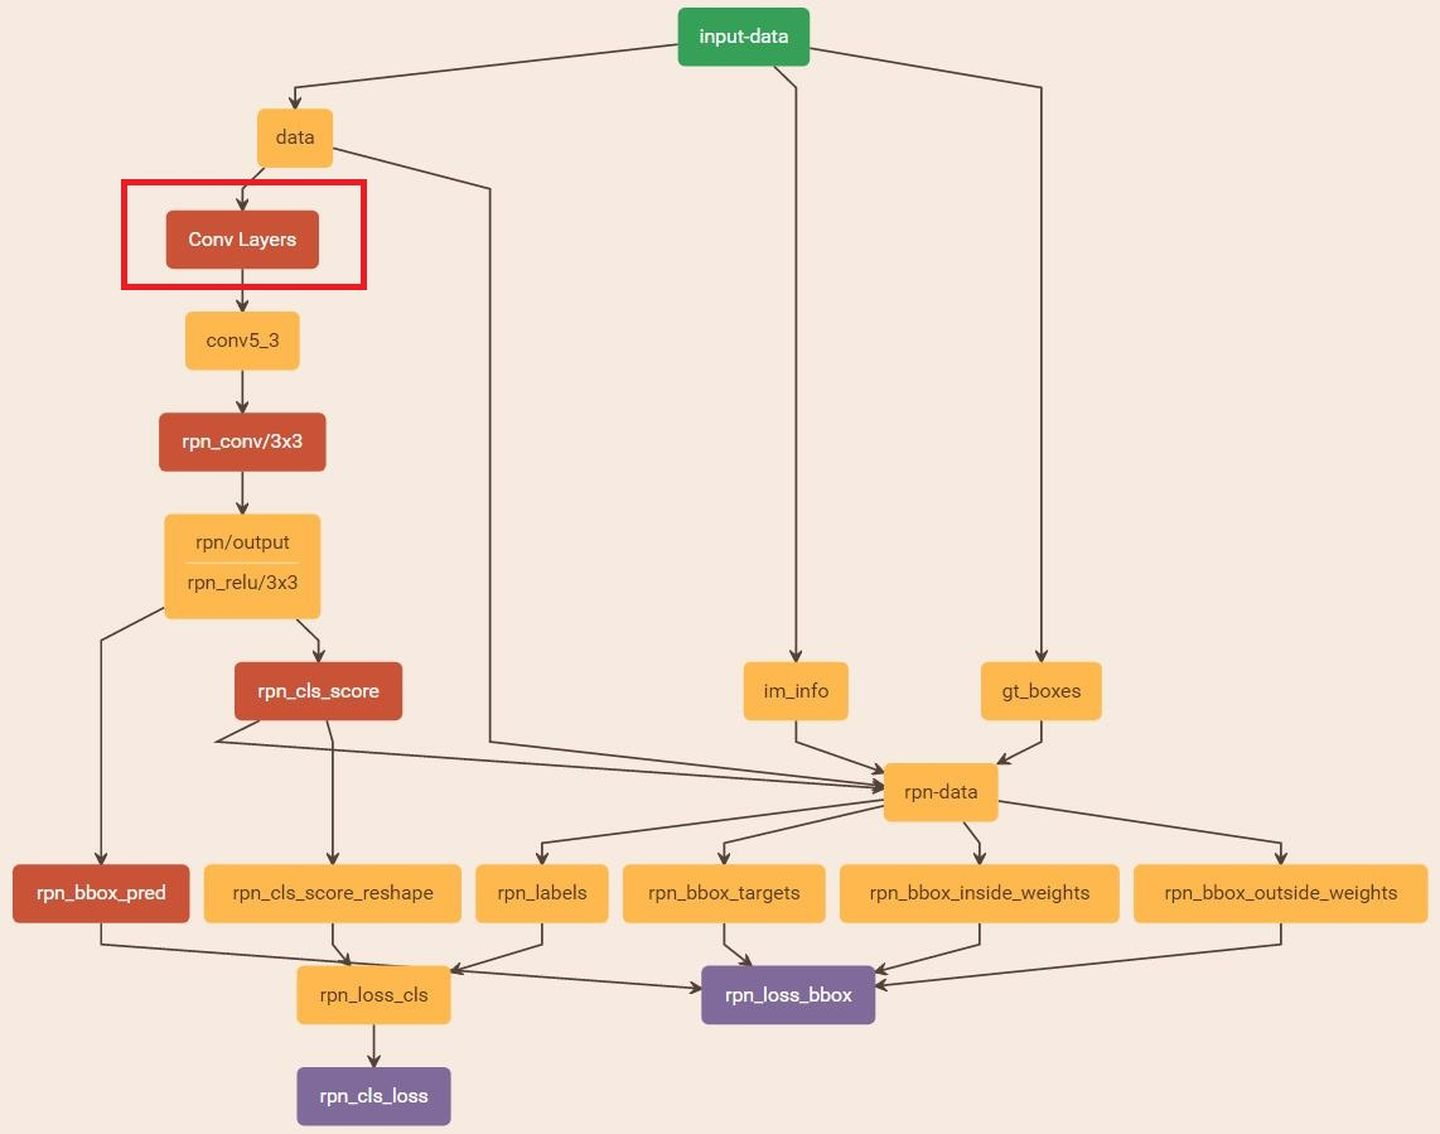

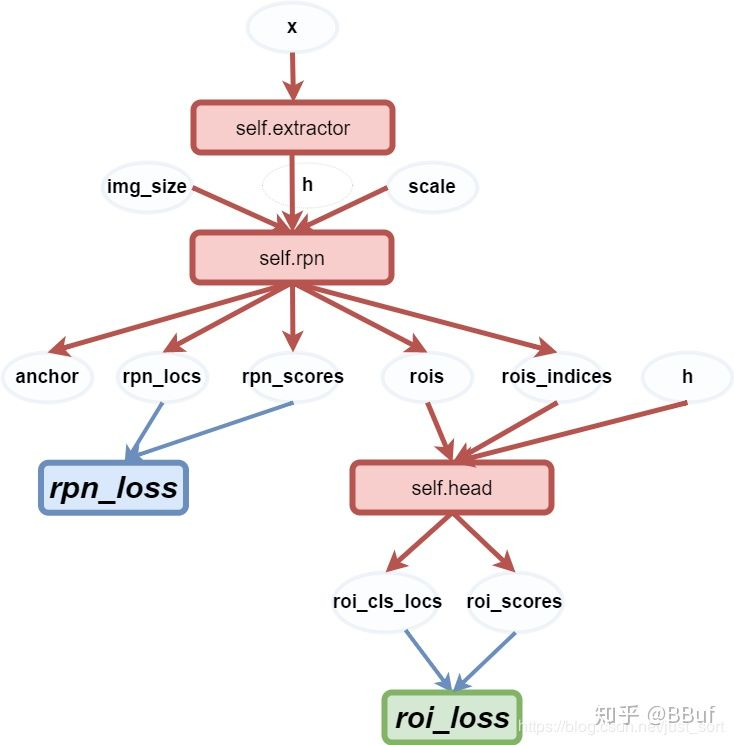
https://zhuanlan.zhihu.com/p/138131253

运行环境tensorflow2.x，使用VOC2007数据集实现Faster-RCNN目标检测算法。
本文将详细介绍并讲解算法的每个模块和每个函数的功能，并可视化一张图片在训练和测试过程中的变化情况。
Faster RCNN首次提出了anchor机制，后续大量流行的SSD、R-CNN、Fast RCNN、Faster RCNN、Mask RCNN和RetinaNet等等
模型都是在建立在anchor基础上的，而yolov3、yolov5等模型尽管对anchor做了一些调整，但出发点不变，
都是从anchor的三个任务和参数化坐标出发，因此，Faster RCNN很重要。

## 1.项目概述

本项目基于2.4+版本的tensorflow，使用VOC2007数据集实现Faster-RCNN目标检测算法。接下来将详细讲解Faster-RCNN算法的每个模块的主要功能，期间通过可视化一张图片在训练和测试过程中如何变化的。

## 2.数据描述

VOC2007数据集的结构如下：
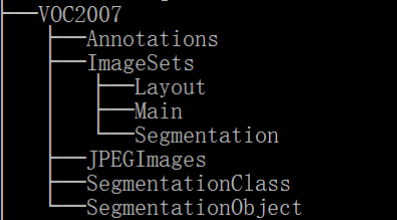

各个目录含义如下：  
1、Annotations中存储的是.xml文件，即标注数据，标注了影像中的目标类型以及边界框bbox；  
2、ImageSet中存储的都是一些txt文件，其实就是各个挑战任务所使用的图片序号，VOC比赛是将所有的图片存在一起，然后不同的挑战任务使用的图片就用一个txt存储使用图片的文件名即可；  
3、JPEGImages文件夹中存储了数据集的所有图片；  
4、SegmentationClass存储了类别分割的标注png。  
5、SegmentationObject存储了实例分割的标注png。
其中类别分割与实例分割的区别是类别分割只区分物体的类别，同样类别的两个不同物体的像素分配同一个值；而实例分割不只区分目标的类别，而且同样类别的两个不同的对象，也要进行区分。例如两个人，在类别分割中都标注为person，而实例分割就需要分割为person1、person2.  
VOC2007数据集的更大介绍可参考：https://www.codenong.com/cs106063597/

## 3.项目流程

1.导入需要的模块  
2.导入数据  
3.提取特征  
4.恢复模型权重参数  
5.可视化训练后的特征图  
6.实现RPN网络  
7.实现RoI Pooling  
8.可视化最后结果  

### 3.1 导入需要的模块

In [1]:
from utils.config import Config
from model.fasterrcnn import FasterRCNNTrainer, FasterRCNN
from model.fasterrcnn import _fast_rcnn_loc_loss

import tensorflow as tf
import numpy as np
from utils.data import Dataset
from utils.nms import nms
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
#读取输入数据形状及所在的路径一些配置信息
config = Config()
config._parse({})

======user config========
{'max_size': 1000,
 'min_size': 600,
 'voc_data_dir': 'C:/Users/wumg/jupyter-ipynb/data/VOC2007/'}
==========end============


### 3.2 导入数据

In [4]:
#导入VOC2007数据集
dataset = Dataset(config)

In [5]:
len(dataset)

5011

In [6]:
#获取数据集中第11张图片和对应的标签
img, bboxes, labels, scale = dataset[11]

In [7]:
for x in (img, bboxes, labels):
    print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

print(scale)

shape: (1, 600, 900, 3) max: 2.64 min: -2.117904
shape: (1, 4) max: 604.8 min: 160.2
shape: (1,) max: 6 min: 6
1.8018018018018018


第11张图片基本信息说明：   
1、img的shape为(1, 600, 900, 3)分别代表了batch维度，图片的高和宽，通道数；  
2、bboxes的类别数及坐标信息，shape为(n, 4)，这里n表示该图片所含的类别总数，最大为20，不包括背景；  
3、labels的shape为（n,）,该图片所含的类别总数，类别代码，这里6表示汽车。  

In [8]:
img_size = img.shape[1:3]
bboxes = tf.cast(bboxes, dtype=tf.float32)

In [9]:
bboxes

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[223.42342, 160.2    , 380.18018, 604.8    ]], dtype=float32)>

In [10]:
#数据集中20中类别
VOC_BBOX_LABEL_NAMES = (
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
    'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')

In [11]:
from utils.data import vis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


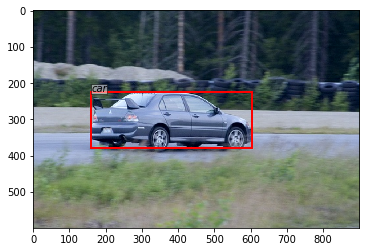

In [12]:
#可视化图片及目标位置
vis(img[0], bboxes, labels)

###  3.3 特征提取

这里使用VGG16作为主干网络（backbone），经过backbone之后，输出为特征图，其形状为(1, 38, 57, 512)，1代表batch size，38和57代表特征图的高度和宽度，数值上为原来(600, 900)的1/16（中间会有向下取整操作），512代表通道数。

In [13]:
import datetime

from utils.config import Config
from model.fasterrcnn import FasterRCNNTrainer, FasterRCNN
import tensorflow as tf
from utils.data import Dataset

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

config = Config()
config._parse({})

print("读取数据中....")
dataset = Dataset(config)


frcnn = FasterRCNN(21, (7, 7))
print('model construct completed')

======user config========
{'max_size': 1000,
 'min_size': 600,
 'voc_data_dir': 'C:/Users/wumg/jupyter-ipynb/data/VOC2007/'}
==========end============
读取数据中....
model construct completed


### 3.4 恢复模型权重参数

In [14]:
#恢复模型前，先实例化模型
frcnn = FasterRCNN(21, (7, 7))
model01 = FasterRCNNTrainer(frcnn)

In [15]:
# 恢复权重参数(weights)
model01.load_weights('./model_weights/')

In [16]:
img, bboxes, labels, scale = dataset[11]
feature_map = model01.faster_rcnn.extractor(img)
print('shape:', feature_map.shape)
print('max:', tf.reduce_max(feature_map).numpy())
print('min:', tf.reduce_min(feature_map).numpy())

shape: (1, 38, 57, 512)
max: 1.3036299
min: 0.0


### 3.5 可视化训练后的特征图（feature_map）
可视化训练后的特征图（feature_map）学到了哪些内容，使用tf.reduce_max()对feature_map最后一维求和，即把512个通道的值加起来，
然后用plt.imshow()绘制出来。从图可以看出，feature map对车的轮廓比较关注

In [17]:
f = tf.reduce_sum(feature_map, axis=-1)

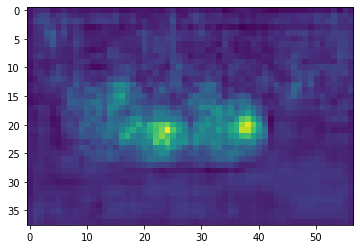

In [18]:
plt.imshow(f[0].numpy())

从上图可以看出，通过训练后得到的特征图（feature map)，已在捕捉到车的轮廓信息。

### 3.6 RPN(Regional Proposal Network)网络
如何生成检测框是目标检测的关键，R-CNN、Fast R-CNN都使用SS(Selective Search)方法生成检测框。而Faster RCNN则抛弃了传统的滑动窗口和SS方法，直接使用RPN生成检测框，这也是Faster R-CNN极大提升检测框的生成速度和效率。
通过主干网提取图像的特征图，接下来，将把特征图输入RPN（Regional Proposal Network）网络。如图所示：
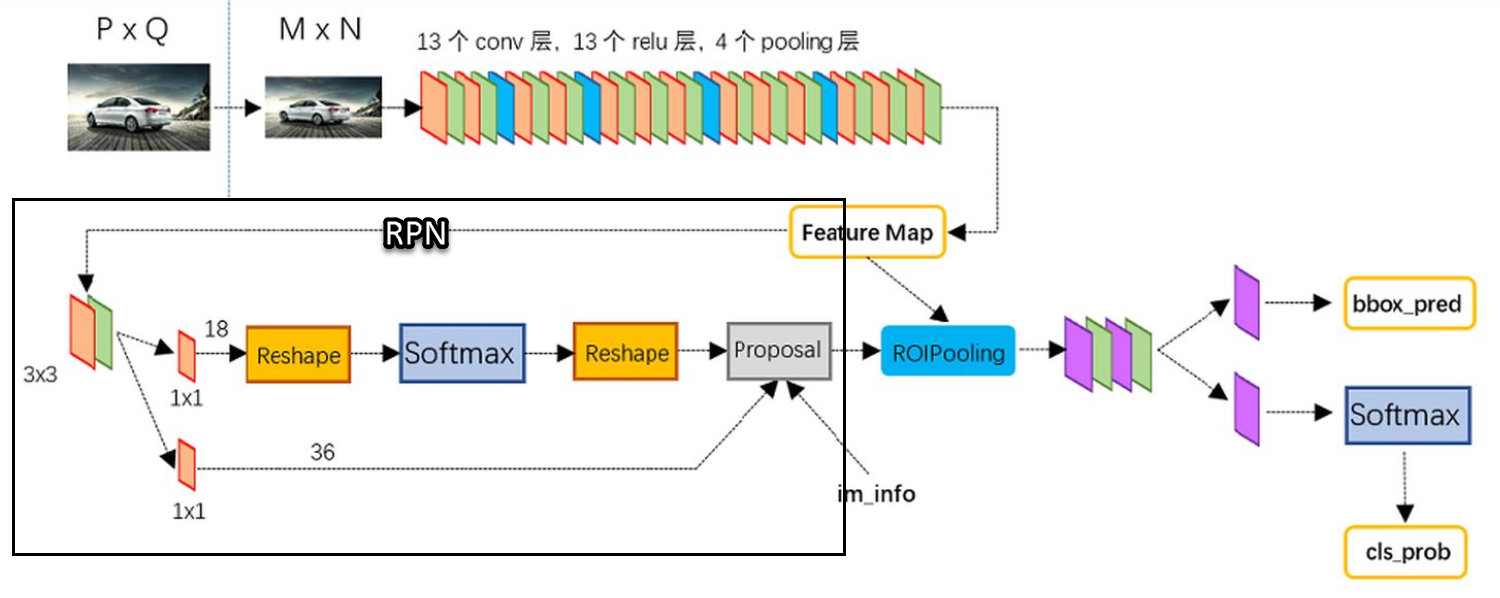

1、RPN 生成 RoIs 的过程如下：  
1.1对于每张图片，利用它的 feature map， 计算 (H/16)× (W/16)×9（大概 20000）个 anchor 属于前景的概率，以及对应的位置参数。  
1.2选取概率较大的 12000 个 anchor    
1.3利用回归的位置参数，修正这 12000 个 anchor 的位置，得到 RoIs  
1.4利用非极大值（(Non-maximum suppression, NMS）抑制，选出概率最大的 2000 个 RoIs   
1.5 RPN的输出主要有rpn_locs(位置偏移量），rpn_score(背景或目标分类分数)，rois，anchor等  
2、RoI pooling层  
给出的 2000 候选框之上继续进行分类和位置参数的回归。由于 RoIs 给出的 2000 个候选框，分别对应 feature map 不同大小的区域。首先利用ProposalTargetCreator 挑选出 128 个 sample_rois, 然后使用了 RoIPooling 将这些不同尺寸的区域全部 pooling 到同一个尺度（7×7）上。  
3、为了使得后续的 FC6、FC7 能够处理大小不同的特征，就把大小不同的特征统一按长宽方向切成 7x7个小区域，每个区域中包含若干个像素，每区域进行pooling，最后统一得到7x7的feature map，便于后续FC6、FC7处理

In [19]:
rpn_locs, rpn_scores, rois, anchor = model01.faster_rcnn.rpn(feature_map, img_size, scale)

上图可知：RPN网络的具体结构分为2条线，
- 上面一条通过softmax分类anchors获得positive（含目标对象）和negative分类（仅为背景）；
在softmax分类时需要进行positive/negative二分类，所以reshape layer会将其变为(1, -1, 2)的形状，做一次softmax，表示每个点上的每个anchor有无目标的得分，即(1, 38×57×9, 2)即（(1, 19494, 2)）大小，即单独留出来一个维度以便softmax分类，之后再reshape回复原状。
- 下面一条用于计算对于anchors的bounding box regression偏移量，以获得精确的proposal。
最后的Proposal层则负责综合positive anchors和对应bounding box regression偏移量获取proposals，
同时过滤太小和超出边界的proposals。

In [20]:
for x in (rpn_locs, rpn_scores, rois, anchor):
    print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

shape: (1, 19494, 4) max: 0.69320536 min: -2.6889641
shape: (1, 19494, 2) max: 7.9172187 min: -7.8503733
shape: (1880, 4) max: 900.0 min: 0.0
shape: (19494, 4) max: 1266.0387 min: -354.03867


In [21]:
img_ = (img[0] * 0.225) + 0.45
img_ = img_.numpy()

### 3.6.1 在特征图上的第一个像素中画出9个anchors
特征图的形状为38×57，每个像素对应9个anchor，这里我们把第一个像素的9个anchor画出来，其中9个anchors，因为3种长宽比(ratio)×3种尺度(scale)而得。

In [22]:
def fig_bbox(bboxes):
    for i in range(len(bboxes)):
        y1 = bboxes[i][0]
        x1 = bboxes[i][1]
        y2 = bboxes[i][2]
        x2 = bboxes[i][3]
        height = y2 - y1
        width = x2 - x1
        ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
        ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


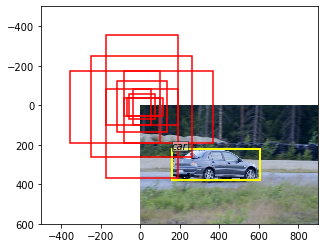

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_)
ax.set_xlim(-500)
ax.set_ylim(600, -500)

fig_bbox(bboxes)

for i in range(0,10):
    y1 = anchor[i][0]
    x1 = anchor[i][1]
    y2 = anchor[i][2]
    x2 = anchor[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

### 3.6.2画出经RPN处理后的proposals

rpn有两个输出：rpn_locs和rpn_scores。其中rpn_locs代表了与目标的区域与一个anchor的相对位置，对每个anchor都生成一维数组
$(d_x, d_y, d_h, d_w)$，共19494份。假设anchor的中心点为$(x_a, y_a)$，高度和宽度为$(h_a, w_a)$，则预测的比较有可能有目标的区域的中心点和宽高为:
这里使用loc2bbox函数将相对位置转换为对应anchor的绝对坐标（y1,x1,y2,x2）。这里画出20个anchors，如下下图所示。

In [24]:
from utils.anchor import loc2bbox

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


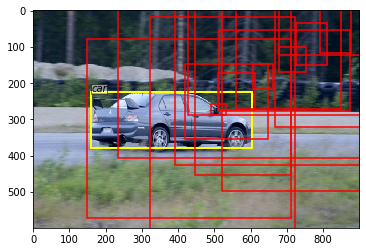

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_)

#画原图及检测框
fig_bbox(bboxes)

rpn_bbox = loc2bbox(anchor, tf.reshape(rpn_locs, [-1,4]).numpy())
for i in range(1000,10000,500):
    y1 = rpn_bbox[i][0]
    x1 = rpn_bbox[i][1]
    y2 = rpn_bbox[i][2]
    x2 = rpn_bbox[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

### 3.6.3 映射到原图像，显示对应的框图

这里的检测框比较粗糙，接下来通过Proposal层对anchor进一步优化，最后输出256个anchors。
在程序中，对应的类是AnchorTargetCreator。通过该类将产生256个anchors。

- 对于每一个真实的bbox(gt_bbox)，选择和它重叠度（IoU）最高的一个anchor作为正样本。
- 对于剩下的anchor，从中选择和任意一个gt_bbox重叠度超过0.7的anchor，作为正样本，正样本的数目不超过128个。
- 随机选择和gt_bbox重叠度小于0.3的anchor作为负样本。负样本和正样本的总数为256。
对于每个anchor, 其label 要么为1（含目标对象），要么为0（仅为背景），所以这样实现二分类。
- 在计算回归损失的时候，只计算正样本的损失，不计算负样本的位置损失。
如下图所示，只有256份相对位置的label不为-1（-1表示anchor boxes在图像之外。）

In [26]:
gt_rpn_loc, gt_rpn_label = model01.anchor_target_creator(bboxes, anchor, img_size)

In [27]:
# 这个对于每一张图是固定的，和训练了多久无关。
for x in (gt_rpn_loc, gt_rpn_label):
    print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

shape: (19494, 4) max: 3.6073492 min: -5.05471
shape: (19494,) max: 1 min: -1


In [28]:
x = gt_rpn_loc[gt_rpn_label != -1]
print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

shape: (256, 4) max: 3.6073492 min: -5.05471


### 这是训练一段时间后的

In [29]:
_fast_rcnn_loc_loss(rpn_locs, gt_rpn_loc, gt_rpn_label, 3.0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.005695459>

In [30]:
training_index = gt_rpn_label != -1

assert len(gt_rpn_loc[training_index]) == 256

training_anchor = anchor[training_index]
training_rpn_locs = tf.reshape(rpn_locs,[-1, 4])[training_index]
training_rpn_scores = tf.reshape(rpn_scores,[-1, 2])[training_index]

### 画出RPN处理后，正负框，即含目标对象（label=1）或仅为背景的框（label=0）

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


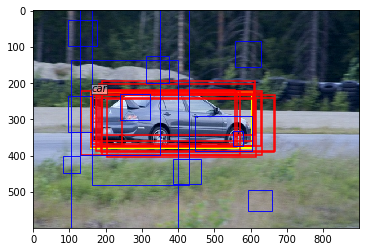

In [31]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_)

fig_bbox(bboxes)

pos_rpn_bbox = rpn_bbox[gt_rpn_label == 1]
for i in range(len(pos_rpn_bbox)):
    y1 = pos_rpn_bbox[i][0]
    x1 = pos_rpn_bbox[i][1]
    y2 = pos_rpn_bbox[i][2]
    x2 = pos_rpn_bbox[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))


neg_rpn_bbox = rpn_bbox[gt_rpn_label == 0]
for i in range(0, len(neg_rpn_bbox), 20):
    y1 = neg_rpn_bbox[i][0]
    x1 = neg_rpn_bbox[i][1]
    y2 = neg_rpn_bbox[i][2]
    x2 = neg_rpn_bbox[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='blue', linewidth=0.9))


In [32]:
rpn_target_bbox = loc2bbox(anchor, gt_rpn_loc)

这里gt_rpn_loc其实就是我们预测rpn_loc的真实值，计算损失值时，选出的256份预测的rpn_loc和gt_rpn_loc越接近越好。如果使用loc2bbox(anchor, gt_rpn_loc)，则得到的bbox是完全和真实的目标框重合的。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


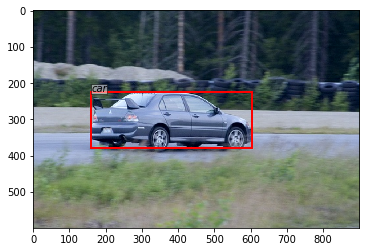

In [33]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_)

fig_bbox(bboxes)

pos_rpn_target_bbox = rpn_target_bbox[gt_rpn_label == 1]
for i in range(len(pos_rpn_target_bbox)):
    y1 = pos_rpn_target_bbox[i][0]
    x1 = pos_rpn_target_bbox[i][1]
    y2 = pos_rpn_target_bbox[i][2]
    x2 = pos_rpn_target_bbox[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

## 4 RoI Pooling
RPN网络生成的proposals的方法：对positive anchors进行bounding box regression，那么这样获得的proposals是大小形状各不相同，RoI Pooling之后就是全连接层，故需要把这些不同形状的proposals变为统一形状，而Faster R-CNN中提出了RoI Pooling解决这个问题。
RoI Pooling Layer：实际上是SPP Layer的简化版，SPP Layer对每个候选区域使用了不同大小的金字塔映射，即SPP Layer采用多个尺度的池化层进行池化操作；而RoI Pooling Layer只需将不同尺度的特征图下采样到一个固定的尺度(例如7x7)。例如对于VGG16网络conv5_3有512个特征图，虽然输入图像的尺寸是任意的，但是通过RoI Pooling Layer后，均会产生一个7x7x512维度的特征向量作为全连接层的输入，即RoI Pooling Layer只采用单一尺度进行池化。如下图所示
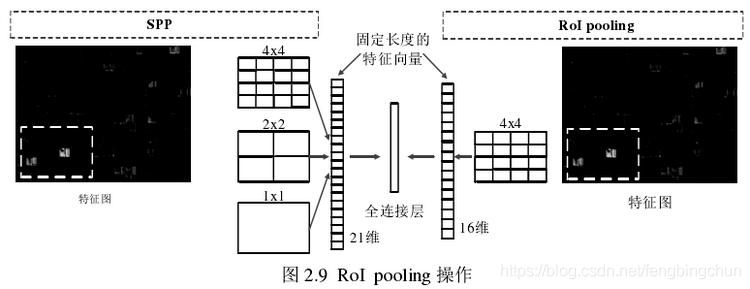
RPN的一个重要输出为rois，其生成过程如下：  
1、将前面约20000份相对位置rpn_locs根据rpn_fg_score（即这一份相对位置是前景的得分）排序，分数越大越靠前，代表程序判断其是前景的概率更大。取分数靠前的12000个。  
2、输入nms，得到不超过2000个rois

### 可视化rois
rois长什么样，这里选择最前面的3个roi，因为nms返回时概率大的靠前，所以这也是最好的3个roi了

In [34]:
tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(gt_rpn_label[training_index], rpn_scores[0][training_index])

<tf.Tensor: shape=(), dtype=float32, numpy=0.52467144>

In [35]:
rois[0]

array([223.82623, 131.8899 , 376.86096, 498.8435 ], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


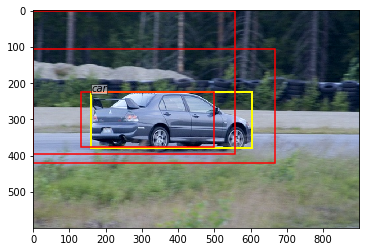

In [36]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_)

fig_bbox(bboxes)


for i in range(3):
    y1 = rois[i][0]
    x1 = rois[i][1]
    y2 = rois[i][2]
    x2 = rois[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

### 对rois进行采样
ROI Pooling/align的输出Tensor形状为(128, 7, 7, 512)代表了128个被选中的roi和各自的(7, 7, 512)特征图。随后，分别进入输出维度为84（21*4）和21的两个全连接层。  
训练时，不会对这所有的917个roi进行训练，而是从中选取了128个。程序里用的操作是ProposalTargetCreator。128个训练roi的选取规则如下：  
1、RoIs和gt_bboxes 的IoU大于0.5的，作为正样本；  
2、选择 RoIs和gt_bboxes的IoU介于0.1和0.5的补足128个作为负样本  

In [37]:
sample_roi, gt_roi_loc, gt_roi_label = model01.proposal_target_creator(rois, bboxes, labels)

In [38]:
for x in (sample_roi, gt_roi_loc, gt_roi_label):
    print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

shape: (128, 4) max: 900.0 min: 0.0
shape: (128, 4) max: 12.325257 min: -11.937229
shape: (128,) max: 7 min: 0


In [39]:
roi_cls_loc, roi_score = model01.faster_rcnn.head(feature_map, sample_roi, img_size)

In [40]:
for x in (roi_cls_loc, roi_score):
    print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

shape: (128, 84) max: 1.0090351 min: -0.5969751
shape: (128, 21) max: 24.611921 min: -1.6320302


这边的gt_roi_label不仅仅是0/1，即是背景还是包括目标对象，而是对应这个区域的具体类别（0代表背景，其余类别对应都往后移了一位，前面我们看到car的标签是6，这里已经变成7了）。不妨先可视化一下，被选中的正roi和负roi长什么样。观察到排在后面的都是负样本，前面的是正样本。

In [41]:
gt_roi_label

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


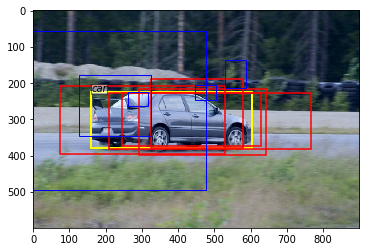

In [42]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_)

fig_bbox(bboxes)

for i in range(5):
    y1 = sample_roi[i][0]
    x1 = sample_roi[i][1]
    y2 = sample_roi[i][2]
    x2 = sample_roi[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

for i in range(100, 105):
    y1 = sample_roi[i][0]
    x1 = sample_roi[i][1]
    y2 = sample_roi[i][2]
    x2 = sample_roi[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='blue', linewidth=1))

根据roi相对于真实目标框的偏移量，对比较有可能有目标的区域再做了一次优化，使用tf.gather_nd来取出真实类别对应的那一份(dx,dy,dh,dw)，并使用loc2bbox(sample_roi, roi_loc.numpy())转化到原图的坐标。

In [43]:
# ROI losses
n_sample = roi_cls_loc.shape[0]
roi_cls_loc = tf.reshape(roi_cls_loc, [n_sample, -1, 4])
idx_ = [[i, j] for i, j in zip(tf.range(n_sample), tf.constant(gt_roi_label))]
roi_loc = tf.gather_nd(roi_cls_loc, idx_)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


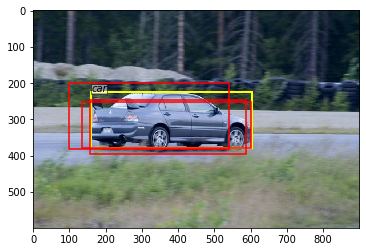

In [44]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_)

fig_bbox(bboxes)


modified_sample_roi = loc2bbox(sample_roi, roi_loc.numpy())
for i in range(3):
    y1 = modified_sample_roi[i][0]
    x1 = modified_sample_roi[i][1]
    y2 = modified_sample_roi[i][2]
    x2 = modified_sample_roi[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

## 5 可视化NMS结果
这里直接选取了真实类别对应的那一份(dx,dy,dh,dw)，通过程序如何实现呢？
使用nms方法，选择roi_score中分数最高的那个框图。

In [45]:
prob = tf.nn.softmax(roi_score, axis=-1)
prob = prob.numpy()
roi_cls_loc = roi_cls_loc.numpy()
roi_cls_loc = roi_cls_loc.reshape(-1, 21, 4)  # 128, 21, 4

In [46]:
modi_roi_bboxes = []
modi_roi_labels = []
modi_roi_scores = []

In [47]:

for label_index in range(1, 21):

    cls_bbox = loc2bbox(sample_roi, roi_cls_loc[:, label_index, :])
    # clip bounding box
    cls_bbox[:, 0::2] = tf.clip_by_value(cls_bbox[:, 0::2], clip_value_min=0, clip_value_max=img_size[0])
    cls_bbox[:, 1::2] = tf.clip_by_value(cls_bbox[:, 1::2], clip_value_min=0, clip_value_max=img_size[1])
    cls_prob = prob[:, label_index]

    mask = cls_prob > 0.05
    cls_bbox = cls_bbox[mask]
    cls_prob = cls_prob[mask]
    keep = tf.image.non_max_suppression(cls_bbox, cls_prob, max_output_size=10, iou_threshold=0.5)


    if len(keep) > 0:
        modi_roi_bboxes.append(cls_bbox[keep.numpy()])
        # The labels are in [0, self.n_class - 2].
        modi_roi_labels.append((label_index - 1) * np.ones((len(keep),)))
        modi_roi_scores.append(cls_prob[keep.numpy()])
if len(bboxes) > 0:
    modi_roi_bboxes = np.concatenate(modi_roi_bboxes, axis=0).astype(np.float32)
    modi_roi_labels = np.concatenate(modi_roi_labels, axis=0).astype(np.float32)
    modi_roi_scores = np.concatenate(modi_roi_scores, axis=0).astype(np.float32)

In [48]:
modi_roi_labels

array([15., 15., 15., 15., 15., 15., 15., 15., 15., 15.], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


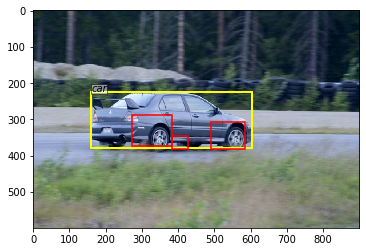

In [49]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_)

for i in range(len(bboxes)):
    y1 = bboxes[i][0]
    x1 = bboxes[i][1]
    y2 = bboxes[i][2]
    x2 = bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})

for i in range(3):
    y1 = modi_roi_bboxes[i][0]
    x1 = modi_roi_bboxes[i][1]
    y2 = modi_roi_bboxes[i][2]
    x2 = modi_roi_bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

通过NMS过滤了很多重合的框